In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [3]:
folder_path = "D:/Projects/News Article classifier/01 Dataset Creation/Pickles//"

filename = "features_test.pickle"
with open(folder_path + filename, "rb") as file:
    features_test = pickle.load(file)
    
filename = "features_train.pickle"
with open(folder_path + filename, "rb") as file:
    features_train = pickle.load(file)
    
filename = "labels_test.pickle"
with open(folder_path + filename, "rb") as file:
    labels_test = pickle.load(file)

filename = "labels_train.pickle"
with open(folder_path + filename, "rb") as file:
    labels_train = pickle.load(file)
    
filename = "data.pickle"
with open(folder_path + filename, "rb") as file:
    data = pickle.load(file)
    

In [4]:
model1 = LogisticRegression(random_state=10)
model1

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
model1.fit(features_train, labels_train)
ypred = model1.predict(features_test)
accuracy_score(ypred, labels_test)

0.9389587073608617

## Grid Search CV
Parameters on which we will can use hyperparameter tuning:   
* C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]   
* multi_class = ['multinomial']   
* solver = ['newton-cg', 'lbfgs', 'sag', 'saga']   
* class_weight = ['balanced', None]   
* penalty = ['l2']   

In [18]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
multi_class = ['multinomial']
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
class_weight = ['balanced', None]
penalty = ['l2']

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 27)

model = LogisticRegression(random_state = 54)

grid_param = {'C' : C,
             'multi_class' : multi_class,
             'solver' : solver,
             'class_weight' : class_weight,
             'penalty' : penalty}

In [19]:
grid_lg = GridSearchCV(estimator = model,
                       param_grid = grid_param, 
                       scoring = "accuracy",
                       n_jobs = -1,
                       cv = cv_sets,
                       verbose = 1)
grid_lg.fit(features_train, labels_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    2.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=27, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=54, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs',

In [20]:
print('Best Score : ', grid_lg.best_score_)
print('Best Parameters : ', grid_lg.best_params_)

Best Score :  0.9594676346037508
Best Parameters :  {'C': 1, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}


In [21]:
best_model = grid_lg.best_estimator_

#### Training Accuracy

In [22]:
print("Training Accuracy : ", accuracy_score(labels_train,best_model.predict(features_train)))

Training Accuracy :  0.9802276812462553


#### Test Accuracy

In [23]:
ypred = best_model.predict(features_test)
print("Test Accuracy : ", accuracy_score(labels_test, ypred))

Test Accuracy :  0.9425493716337523


#### Classification Report

In [24]:
print(classification_report(labels_test, ypred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       116
           1       0.92      0.95      0.94       107
           2       0.93      0.93      0.93        99
           3       0.98      0.98      0.98       138
           4       0.95      0.93      0.94        97

    accuracy                           0.94       557
   macro avg       0.94      0.94      0.94       557
weighted avg       0.94      0.94      0.94       557



#### Confusion Matrix

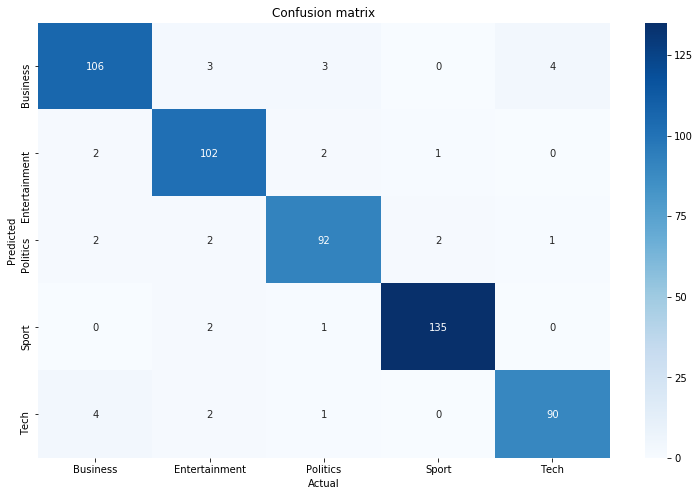

In [26]:
aux_df = data[['Category', 'Category_codes']].drop_duplicates().sort_values('Category_codes')
conf_matrix = confusion_matrix(labels_test, ypred)

plt.figure(figsize=(12.8,8))
ax = sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues", fmt = 'g')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()


We will create a dataframe with Model Name, Training Accuracy and Test Accuracy to compare later

In [27]:
models_summary = pd.DataFrame({"Model Name:" : ["Logistic Regression"],
     "Training Accuracy" : [accuracy_score(labels_train, best_model.predict(features_train))],
     "Test Accuracy" : [accuracy_score(labels_test, ypred)]}, index = [5])

In [28]:
models_summary

,Model Name:,Training Accuracy,Test Accuracy
5,Logistic Regression,0.980228,0.942549


In [29]:
with open("Models//models_summary.pickle", "rb") as file:
    all_models_summary = pickle.load(file)
all_models_summary = all_models_summary.append(models_summary)
all_models_summary

,Model Name:,Training Accuracy,Test Accuracy
0,Random Forest Classifier,1.000000,0.960503
1,Gradient Boosting Classifier,1.000000,0.958707
2,Support Vector Machine,1.000000,0.944345
3,KNN,0.928700,0.910233
4,MultinomialNB,0.956261,0.938959
5,Logistic Regression,0.980228,0.942549


In [30]:
with open("Models//best_logr.pickle", "wb") as output:
    pickle.dump(best_model, output)
    
with open("Models//models_summary.pickle", "wb") as output:
    pickle.dump(all_models_summary, output)